# Streetcar Delay Prediction - Data Preparation

Use dataset covering Toronto Transit Commission (TTC) streetcar delays 2014 - present to predict future delays and come up with recommendations for avoiding delays.

Source dataset: : https://www.toronto.ca/city-government/data-research-maps/open-data/open-data-catalogue/#e8f359f0-2f47-3058-bf64-6ec488de52da

This notebook contains the common data loading and preparation steps:
- load data from all the tabs of all the XLS files into a single dataframe
- correct type issues
- fix missing values
- clean up anomalies in the location, direction and vehicle columns

# Streetcar routes

From https://www.ttc.ca/Routes/Streetcars.jsp

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcar%20routes.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs CLRV/ALRV

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarCLRV.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

# Streetcar vehicle IDs Flexity

From https://en.wikipedia.org/wiki/Toronto_streetcar_system_rolling_stock#CLRVs_and_ALRVs

<table style="border: none" align="left">
   </tr>
   <tr style="border: none">
       <th style="border: none"><img src="https://raw.githubusercontent.com/ryanmark1867/streetcarnov3/master/streetcarflexity.jpg" width="600" alt="Icon"> </th>
   </tr>
</table>

In [415]:
# load the valid list of TTC Streetcar routes
valid_routes = ['501','502','503','504','505','506','509','510','511','512','301','304','306','310']

In [416]:
valid_routes

['501',
 '502',
 '503',
 '504',
 '505',
 '506',
 '509',
 '510',
 '511',
 '512',
 '301',
 '304',
 '306',
 '310']

In [417]:
# original valid directions
# valid_directions = ['E/B','W/B','N/B','S/B','B/W']
# revised valid directions to include lowercasing and removal of '/' and simplify to single letter
valid_directions = ['e','w','n','s','b']

In [418]:
valid_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [419]:
! pwd

/notebooks/manning/notebooks


# Load and Save Data
- parse list of XLS files 
- load XLS files, tab by tab, into dataframe
- pickle dataframe for future runs

In [420]:
# variables to control function of this notebook
# control whether to load data from scratch from original source or from saved dataframe
load_from_scratch = False
# control whether to save dataframe with transformed data
save_transformed_dataframe = True

In [421]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# import seaborn as sns
import datetime
import os


In [422]:
# get the directory for that this notebook is in
rawpath = os.getcwd()
print("raw path is",rawpath)

raw path is /notebooks/manning/notebooks


In [423]:
# data is in a directory called "data" that is a sibling to the directory containing the notebook
path = os.path.abspath(os.path.join(rawpath, '..', 'data')) + "/"
print("path is", path)

path is /notebooks/manning/data/


In [424]:
# pickled_dataframe = '20142018_df.pkl'
pickled_input_dataframe = '2014_2018.pkl'
pickled_output_dataframe = '2014_2018_df.pkl'
# path,picklename,firstfile, firstsheet



In [425]:
# given a path return the list of xls files in the directory
def get_xls_list(path):
    files = os.listdir(path)
    files_xls = [f for f in files if f[-4:] == 'xlsx']
    print(files)
    print(files_xls)
    return(files_xls)


In [426]:
# load all the tabs of all the XLS files in a list of XLS files, minus tab that has seeded dataframe
def load_xls(path, files_xls, firstfile, firstsheet, df):
    for f in files_xls:
        print("file name",f)
        xlsf = pd.ExcelFile(path+f)
        # iterate through sheets
        for sheet_name in xlsf.sheet_names:
            print("sheet_name",sheet_name)
            if (f != firstfile) or (sheet_name != firstsheet):
                print("sheet_name in loop",sheet_name)
                data = pd.read_excel(path+f,sheetname=sheet_name)    
                df = df.append(data)
    return (df)

In [427]:
# given a path and a filename, load all the XLS files in the path into a dataframe and save
# to the dataframe to the filename
def reloader(path,picklename):
    # get list of all xls files in the path
    files_xls = get_xls_list(path)
    print("list of xls",files_xls)
    # seed initial tab on initial xls file
    dfnew = pd.read_excel(path+files_xls[0])
    # get the list of sheets in the first file
    xlsf = pd.ExcelFile(path+files_xls[0])
    # load the remaining tabs from all the other xls
    # pass the first file (files_xls[0]) and the first tab in that file (xlsf[0]) explicitly
    dflatest = load_xls(path,files_xls,files_xls[0],xlsf.sheet_names[0], dfnew)
    # save dataframe to pickle
    dflatest.to_pickle(path+ picklename)
    # return dataframe loaded with all tabs of all xls files
    return(dflatest)
    

In [428]:
# define categories for input columns
def define_feature_categories(df):
    allcols = list(df)
    print("all cols",allcols)
    textcols = ['Incident','Location'] # 
    continuouscols = ['Min Delay','Min Gap'] 
                      # columns to deal with as continuous values - no embeddings
    timecols = ['Report Date','Time']
    collist = ['Day','Vehicle','Route','Direction']
    for col in continuouscols:
        df[col] = df[col].astype(float)
    print('texcols: ',textcols)
    print('continuouscols: ',continuouscols)
    print('timecols: ',timecols)
    print('collist: ',collist)
    return(allcols,textcols,continuouscols,timecols,collist)

In [429]:
# fill missing values according to the column category
def fill_missing(dataset):
    print("before mv")
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)

# Load dataframe and add columns for time series manipulation
- load pickled dataframe
- show info about the dataset
- build index combining date+time along with labelled column date+time


In [430]:
# read in previously pickled dataframe containing data from s/s 2014 - 2018
if load_from_scratch:
    unpickled_df = reloader(path,pickled_input_dataframe)
    print("reloader done")
    #unpickled_df = pd.read_pickle(path+pickled_data_file)
else:
    unpickled_df = pd.read_pickle(path+pickled_input_dataframe)

In [431]:
df = unpickled_df
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092.0
1,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030.0
2,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147.0
3,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049.0
4,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114.0


In [432]:
# ensure Route and Vehicle are strings, not numeric
# df = df.astype({"Route": str, "Vehicle": int})
df['Route'] = df['Route'].astype(str)
df['Vehicle'] = df['Vehicle'].astype(str)
# df['filename'] = df['filename'].str[:-4]
df['Vehicle'] = df['Vehicle'].str[:-2]
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle
0,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092
1,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030
2,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147
3,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049
4,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114


In [433]:
# define categories
allcols,textcols,continuouscols,timecols,collist = define_feature_categories(df) 

all cols ['Report Date', 'Route', 'Time', 'Day', 'Location', 'Incident', 'Min Delay', 'Min Gap', 'Direction', 'Vehicle']
texcols:  ['Incident', 'Location']
continuouscols:  ['Min Delay', 'Min Gap']
timecols:  ['Report Date', 'Time']
collist:  ['Day', 'Vehicle', 'Route', 'Direction']


In [434]:
# fill in missing values
df = fill_missing(df)

before mv


In [435]:
# getting some information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83365 entries, 0 to 1519
Data columns (total 10 columns):
Report Date    83365 non-null datetime64[ns]
Route          83365 non-null object
Time           83365 non-null object
Day            83365 non-null object
Location       83365 non-null object
Incident       83365 non-null object
Min Delay      83365 non-null float64
Min Gap        83365 non-null float64
Direction      83365 non-null object
Vehicle        83365 non-null object
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 7.0+ MB


In [436]:
# getting some information about dataset
df.shape

(83365, 10)

In [437]:
# further Analysis 
df.describe()

,Min Delay,Min Gap
count,83365.000000,83365.000000
mean,12.630229,18.103209
std,29.939810,33.000675
min,0.000000,0.000000
25%,5.000000,9.000000
50%,6.000000,12.000000
75%,11.000000,20.000000
max,1400.000000,4216.000000


In [438]:
df.dtypes

Report Date    datetime64[ns]
Route                  object
Time                   object
Day                    object
Location               object
Incident               object
Min Delay             float64
Min Gap               float64
Direction              object
Vehicle                object
dtype: object

In [439]:
# create new column combing date + time (needed for resampling) and make it the index

df['Report Date Time'] = pd.to_datetime(df['Report Date'].astype(str) + ' ' + df['Time'].astype(str))
df.index = df['Report Date Time']
df.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,Broadview and Gerrard,Mechanical,9.0,18.0,S/B,4092,2015-01-01 01:25:00
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,Roncesvalles and Galley,Held By,14.0,23.0,S/B,4030,2015-01-01 01:44:00
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,King and Sherborne,Mechanical,9.0,18.0,E/B,4147,2015-01-01 02:04:00
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,Main St. and Upper Gerard,Investigation,29.0,39.0,S/B,4049,2015-01-01 02:12:00
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,Gerrard and Sumach,Mechanical,30.0,60.0,W/B,4114,2015-01-01 05:05:00


# Additional data explorations

In [440]:
# the values in the location column were entered in free form, so there are several problems to fix

# start by counting the distinct values in location column before and after lowercasing
print("Unique Location values:",df['Location'].nunique())
df['Location'] = df['Location'].str.lower()
print("Unique Location values after lcasing:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Unique Location values: 15691
Unique Location values after lcasing: 13263


russell yard                 1805
roncy yard                   1385
queen and connaught          1158
roncesvalles yard            1088
roncesvalles and queen       1046
leslie barns                  936
queen and roncesvalles        846
broadview station             827
dundas west station           812
cne loop                      794
broadview stn                 667
humber loop                   625
broadview and queen           622
queen at connaught            573
spadina and king              519
neville loop                  498
main station                  495
bingham loop                  488
bathurst station              488
king and spadina              451
dundas west stn               443
coxwell and gerrard           437
roncesvalles yard.            435
queen and broadview           423
spadina station               415
broadview and dundas          351
queen at roncesvalles         346
long branch loop              332
exhibition loop               318
longbranch loo

In [441]:
# make substitutions to eliminate obvious duplicate tokens, counting unique values before and after
# need to add a function to flip "x and y" consistently
print("Unique Location values before substitutions:",df['Location'].nunique())
df['Location'] = df['Location'].replace({'broadviewstation':'broadview station',' at ':' and ',' stn':' station',' ave.':'','/':' and ','roncy':'roncesvalles','carhouse':'yard','yard.':'yard','st. clair':'st clair','ronc. ':'roncesvalles ','long branch':'longbranch','garage':'yard','barns':'yard',' & ':' and '}, regex=True)
print("Unique Location values after substitutions:",df['Location'].nunique())
df['Location'].value_counts().head(50)

Unique Location values before substitutions: 13263
Unique Location values after substitutions: 10867


roncesvalles yard               3951
russell yard                    2050
queen and connaught             1995
roncesvalles and queen          1896
broadview station               1494
queen and roncesvalles          1392
dundas west station             1255
leslie yard                     1052
broadview and queen              805
cne loop                         794
spadina and king                 770
bathurst station                 768
king and spadina                 727
main station                     655
longbranch loop                  649
queen and broadview              641
spadina station                  626
humber loop                      625
broadview and dundas             586
coxwell and gerrard              525
neville loop                     498
bingham loop                     488
st clair west station            477
king and bathurst                441
broadview and gerrard            418
bathurst and king                411
howard park and roncesvalles     405
b

In [442]:
df['Location'].value_counts().head(80)

roncesvalles yard                           3951
russell yard                                2050
queen and connaught                         1995
roncesvalles and queen                      1896
broadview station                           1494
queen and roncesvalles                      1392
dundas west station                         1255
leslie yard                                 1052
broadview and queen                          805
cne loop                                     794
spadina and king                             770
bathurst station                             768
king and spadina                             727
main station                                 655
longbranch loop                              649
queen and broadview                          641
spadina station                              626
humber loop                                  625
broadview and dundas                         586
coxwell and gerrard                          525
neville loop        

In [443]:
def clean_conjunction(intersection):
    # make conjunctions in intersections consistent
    if " and " not in intersection:
        if "&" in intersection:
            if " & " in intersection:
                intersection.replace(" & "," and ")
            else:
                if "&" in intersection:
                    intersection.replace("&"," and ")
        else:
            if " / " in intersection:
                intersection.replace(" / "," and ")
            else:
                if "/" in intersection:
                    intersection.replace("/"," and ")
    return(intersection)

In [444]:
def order_location(intersection):
    # for any string with the format "* and *" if the value before the and is alphabetically
    # higher than the value after the and, swap the values
    conj = " and "
    alpha_ordered_intersection = intersection
    if conj in intersection:
        end_first_street = intersection.find(conj)
        if (end_first_street > 0) and (len(intersection) > (end_first_street + len(conj))):
            start_second_street = intersection.find(conj) + len(conj)
            first_street = intersection[0:end_first_street]
            second_street = intersection[start_second_street:]
            alpha_ordered_intersection = min(first_street,second_street)+conj+max(first_street,second_street)
    return(alpha_ordered_intersection)
                                       
                                       
           
                                       
        

In [445]:
# put intersection values into consistent order
print("Unique Location values:",df['Location'].nunique())
df['Location'] = df['Location'].apply(lambda x:order_location(x))
print("Unique Location values after lcasing:",df['Location'].nunique())
df['Location'].value_counts().head(100)

Unique Location values: 10867
Unique Location values after lcasing: 10074


roncesvalles yard               3951
queen and roncesvalles          3288
connaught and queen             2222
russell yard                    2050
king and spadina                1497
broadview station               1494
broadview and queen             1446
dundas west station             1255
leslie yard                     1052
coxwell and gerrard              867
bathurst and king                852
broadview and dundas             850
cne loop                         794
bathurst station                 768
howard park and roncesvalles     728
broadview and gerrard            661
main station                     655
longbranch loop                  649
spadina station                  626
humber loop                      625
queen and spadina                571
bathurst and st clair            513
neville loop                     498
bingham loop                     488
bathurst and queen               479
bathurst and fleet               478
st clair west station            477
b

In [446]:
print("route count",df['Route'].nunique())
df['Route'].value_counts()

route count 106


501    21160
504    15862
506    11361
505     8947
512     6354
510     5291
511     4208
509     2817
514     2086
502     1746
503     1027
301      891
306      356
705      209
304      205
805      192
508      137
535       53
317       52
50        50
310       49
807       23
5         22
51        21
1         20
4         11
500       11
11         8
3          8
8          8
       ...  
24         2
31         1
519        1
68         1
204        1
53         1
830        1
701        1
86         1
210        1
28         1
594        1
513        1
19         1
85         1
45         1
205        1
93         1
375        1
63         1
403        1
999        1
21         1
804        1
81         1
111        1
13         1
57         1
60         1
405        1
Name: Route, Length: 106, dtype: int64

In [447]:
def check_route (x):
    if x in valid_routes:
        return(x)
    else:
        return("bad route")

In [448]:
# apply(lambda x:findEmpty(x) df['Route'].apply(lambda x:check_route(x))
df['Route'] = df['Route'].apply(lambda x:check_route(x))

In [449]:
print("route count",df['Route'].nunique())
df['Route'].value_counts()

route count 15


501          21160
504          15862
506          11361
505           8947
512           6354
510           5291
511           4208
bad route     3091
509           2817
502           1746
503           1027
301            891
306            356
304            205
310             49
Name: Route, dtype: int64

In [450]:
df[df.Vehicle == 'n'].shape[0]

5552

In [451]:
df['Vehicle'].shape[0]

83365

In [452]:
def check_vehicle (x):
    if str.isdigit(x):
        if int(x) >= 4000 and int(x) < 4600:
            return x
        else:
            print("bad vehicle is",x)
            return("bad vehicle")
    else:
        return("bad vehicle")

In [453]:
def check_direction (x):
    if x in valid_directions:
        return(x)
    else:
        return("bad direction")

In [454]:
df['Vehicle'].value_counts()

n       5552
4074     330
4199     320
4101     316
4209     314
4229     308
4204     307
4176     306
4247     304
4144     302
4218     300
4115     299
4050     299
4200     298
4001     297
4147     294
4222     293
4185     291
4149     290
4141     288
4215     288
4210     287
4152     287
4048     286
4110     286
4208     286
4143     284
4181     283
4217     282
4403     280
        ... 
3263       1
1581       1
8591       1
8769       1
8726       1
4255       1
7645       1
1231       1
1786       1
7648       1
8818       1
1220       1
22         1
5664       1
8512       1
8425       1
7227       1
7232       1
8886       1
8729       1
7628       1
8706       1
6956       1
8010       1
7918       1
1274       1
8607       1
8834       1
8832       1
438        1
Name: Vehicle, Length: 2438, dtype: int64

In [455]:
print("vehicle count",df['Vehicle'].nunique())
df['Vehicle'] = df['Vehicle'].apply(lambda x:check_vehicle(x))
df['Vehicle'].value_counts()

vehicle count 2438
bad vehicle is 1054
bad vehicle is 7776
bad vehicle is 8173
bad vehicle is 512
bad vehicle is 0
bad vehicle is 1224
bad vehicle is 0
bad vehicle is 1596
bad vehicle is 1048
bad vehicle is 512
bad vehicle is 1039
bad vehicle is 417
bad vehicle is 1548
bad vehicle is 1543
bad vehicle is 1397
bad vehicle is 1614
bad vehicle is 7795
bad vehicle is 7736
bad vehicle is 7824
bad vehicle is 1035
bad vehicle is 1635
bad vehicle is 1015
bad vehicle is 8059
bad vehicle is 8027
bad vehicle is 7686
bad vehicle is 7878
bad vehicle is 1273
bad vehicle is 7700
bad vehicle is 1507
bad vehicle is 1510
bad vehicle is 1026
bad vehicle is 9042
bad vehicle is 7740
bad vehicle is 4
bad vehicle is 7413
bad vehicle is 1650
bad vehicle is 7853
bad vehicle is 6007
bad vehicle is 1283
bad vehicle is 415
bad vehicle is 1034
bad vehicle is 7811
bad vehicle is 7740
bad vehicle is 7783
bad vehicle is 7770
bad vehicle is 424
bad vehicle is 1547
bad vehicle is 7770
bad vehicle is 2382
bad vehicle is 

bad vehicle is 9428
bad vehicle is 9441
bad vehicle is 0
bad vehicle is 9410
bad vehicle is 9437
bad vehicle is 9413
bad vehicle is 9439
bad vehicle is 7551
bad vehicle is 8340
bad vehicle is 7559
bad vehicle is 7497
bad vehicle is 1079
bad vehicle is 7591
bad vehicle is 7322
bad vehicle is 7483
bad vehicle is 7967
bad vehicle is 7330
bad vehicle is 8080
bad vehicle is 9426
bad vehicle is 9442
bad vehicle is 9432
bad vehicle is 501
bad vehicle is 7972
bad vehicle is 505
bad vehicle is 7564
bad vehicle is 7683
bad vehicle is 1780
bad vehicle is 9408
bad vehicle is 8084
bad vehicle is 7325
bad vehicle is 7342
bad vehicle is 7618
bad vehicle is 8088
bad vehicle is 7407
bad vehicle is 8089
bad vehicle is 40
bad vehicle is 8061
bad vehicle is 7851
bad vehicle is 8021
bad vehicle is 7738
bad vehicle is 9444
bad vehicle is 7478
bad vehicle is 9409
bad vehicle is 9408
bad vehicle is 0
bad vehicle is 7531
bad vehicle is 8363
bad vehicle is 7961
bad vehicle is 8062
bad vehicle is 0
bad vehicle i

bad vehicle is 7570
bad vehicle is 7340
bad vehicle is 7570
bad vehicle is 7577
bad vehicle is 9433
bad vehicle is 7737
bad vehicle is 9402
bad vehicle is 7872
bad vehicle is 7684
bad vehicle is 7706
bad vehicle is 9431
bad vehicle is 7857
bad vehicle is 7869
bad vehicle is 9432
bad vehicle is 7840
bad vehicle is 7802
bad vehicle is 9413
bad vehicle is 7472
bad vehicle is 7629
bad vehicle is 7545
bad vehicle is 9414
bad vehicle is 9403
bad vehicle is 8041
bad vehicle is 8031
bad vehicle is 8302
bad vehicle is 7588
bad vehicle is 7641
bad vehicle is 7443
bad vehicle is 7503
bad vehicle is 9436
bad vehicle is 9433
bad vehicle is 7663
bad vehicle is 9413
bad vehicle is 7473
bad vehicle is 8080
bad vehicle is 7435
bad vehicle is 7428
bad vehicle is 7431
bad vehicle is 7591
bad vehicle is 7599
bad vehicle is 7509
bad vehicle is 8030
bad vehicle is 7706
bad vehicle is 8305
bad vehicle is 8179
bad vehicle is 7333
bad vehicle is 8305
bad vehicle is 9448
bad vehicle is 9439
bad vehicle is 7531


bad vehicle is 1268
bad vehicle is 8600
bad vehicle is 8385
bad vehicle is 8131
bad vehicle is 8131
bad vehicle is 501
bad vehicle is 8129
bad vehicle is 8191
bad vehicle is 1092
bad vehicle is 1022
bad vehicle is 1142
bad vehicle is 8931
bad vehicle is 1091
bad vehicle is 8521
bad vehicle is 1084
bad vehicle is 1022
bad vehicle is 8953
bad vehicle is 8134
bad vehicle is 8559
bad vehicle is 8943
bad vehicle is 8134
bad vehicle is 8495
bad vehicle is 8559
bad vehicle is 8950
bad vehicle is 8212
bad vehicle is 9203
bad vehicle is 8341
bad vehicle is 8163
bad vehicle is 1040
bad vehicle is 1143
bad vehicle is 1040
bad vehicle is 8132
bad vehicle is 8383
bad vehicle is 8511
bad vehicle is 1804
bad vehicle is 8132
bad vehicle is 8132
bad vehicle is 9235
bad vehicle is 8336
bad vehicle is 8474
bad vehicle is 8596
bad vehicle is 1417
bad vehicle is 8578
bad vehicle is 1013
bad vehicle is 1241
bad vehicle is 1549
bad vehicle is 1146
bad vehicle is 8554
bad vehicle is 8135
bad vehicle is 1048
b

bad vehicle is 1504
bad vehicle is 1500
bad vehicle is 8099
bad vehicle is 8870
bad vehicle is 8167
bad vehicle is 1667
bad vehicle is 1389
bad vehicle is 7777
bad vehicle is 1618
bad vehicle is 1667
bad vehicle is 8035
bad vehicle is 1210
bad vehicle is 1224
bad vehicle is 1389
bad vehicle is 1073
bad vehicle is 1056
bad vehicle is 7862
bad vehicle is 1210
bad vehicle is 8323
bad vehicle is 8339
bad vehicle is 1596
bad vehicle is 8339
bad vehicle is 8301
bad vehicle is 8320
bad vehicle is 8891
bad vehicle is 1646
bad vehicle is 506
bad vehicle is 1050
bad vehicle is 8383
bad vehicle is 7774
bad vehicle is 1791
bad vehicle is 8152
bad vehicle is 1409
bad vehicle is 1287
bad vehicle is 8308
bad vehicle is 417
bad vehicle is 8150
bad vehicle is 1033
bad vehicle is 7776
bad vehicle is 7878
bad vehicle is 7812
bad vehicle is 8157
bad vehicle is 7878
bad vehicle is 8161
bad vehicle is 7709
bad vehicle is 1065
bad vehicle is 1421
bad vehicle is 7943
bad vehicle is 8045
bad vehicle is 8078
ba

bad vehicle is 512
bad vehicle is 7744
bad vehicle is 8955
bad vehicle is 7724
bad vehicle is 8168
bad vehicle is 1359
bad vehicle is 8203
bad vehicle is 8060
bad vehicle is 8401
bad vehicle is 7832
bad vehicle is 501
bad vehicle is 504
bad vehicle is 8167
bad vehicle is 7880
bad vehicle is 1808
bad vehicle is 1525
bad vehicle is 8953
bad vehicle is 8044
bad vehicle is 8393
bad vehicle is 1066
bad vehicle is 1092
bad vehicle is 8125
bad vehicle is 7776
bad vehicle is 7857
bad vehicle is 8043
bad vehicle is 1362
bad vehicle is 7745
bad vehicle is 8135
bad vehicle is 1011
bad vehicle is 1384
bad vehicle is 511
bad vehicle is 8077
bad vehicle is 8139
bad vehicle is 1617
bad vehicle is 1562
bad vehicle is 7745
bad vehicle is 8167
bad vehicle is 7858
bad vehicle is 504
bad vehicle is 7883
bad vehicle is 1523
bad vehicle is 1111
bad vehicle is 1025
bad vehicle is 1532
bad vehicle is 8125
bad vehicle is 7821
bad vehicle is 1503
bad vehicle is 1540
bad vehicle is 7730
bad vehicle is 9200
bad v

bad vehicle is 9212
bad vehicle is 7969
bad vehicle is 8125
bad vehicle is 8116
bad vehicle is 8068
bad vehicle is 8116
bad vehicle is 1683
bad vehicle is 8194
bad vehicle is 7731
bad vehicle is 9201
bad vehicle is 501
bad vehicle is 8486
bad vehicle is 8678
bad vehicle is 8164
bad vehicle is 1234
bad vehicle is 1329
bad vehicle is 9214
bad vehicle is 8068
bad vehicle is 8037
bad vehicle is 1819
bad vehicle is 7846
bad vehicle is 1819
bad vehicle is 1390
bad vehicle is 8195
bad vehicle is 8157
bad vehicle is 1394
bad vehicle is 1020
bad vehicle is 9230
bad vehicle is 1091
bad vehicle is 7837
bad vehicle is 7957
bad vehicle is 1418
bad vehicle is 7813
bad vehicle is 1074
bad vehicle is 7833
bad vehicle is 1351
bad vehicle is 8376
bad vehicle is 8032
bad vehicle is 7737
bad vehicle is 8121
bad vehicle is 1051
bad vehicle is 7975
bad vehicle is 7782
bad vehicle is 8043
bad vehicle is 8301
bad vehicle is 8330
bad vehicle is 0
bad vehicle is 9218
bad vehicle is 8630
bad vehicle is 8368
bad 

bad vehicle is 1796
bad vehicle is 8065
bad vehicle is 7820
bad vehicle is 8960
bad vehicle is 7717
bad vehicle is 7869
bad vehicle is 7744
bad vehicle is 1094
bad vehicle is 8391
bad vehicle is 1004
bad vehicle is 7845
bad vehicle is 7845
bad vehicle is 7786
bad vehicle is 1393
bad vehicle is 1823
bad vehicle is 8391
bad vehicle is 8067
bad vehicle is 8937
bad vehicle is 8110
bad vehicle is 1364
bad vehicle is 7875
bad vehicle is 8368
bad vehicle is 8449
bad vehicle is 8852
bad vehicle is 4
bad vehicle is 7735
bad vehicle is 8378
bad vehicle is 8118
bad vehicle is 1134
bad vehicle is 7727
bad vehicle is 8035
bad vehicle is 7767
bad vehicle is 7926
bad vehicle is 9208
bad vehicle is 7876
bad vehicle is 1595
bad vehicle is 7858
bad vehicle is 1681
bad vehicle is 1281
bad vehicle is 1140
bad vehicle is 7745
bad vehicle is 8119
bad vehicle is 7800
bad vehicle is 7805
bad vehicle is 8016
bad vehicle is 1681
bad vehicle is 1606
bad vehicle is 8153
bad vehicle is 8046
bad vehicle is 8187
bad

bad vehicle is 1411
bad vehicle is 1411
bad vehicle is 7841
bad vehicle is 7751
bad vehicle is 7730
bad vehicle is 7713
bad vehicle is 1349
bad vehicle is 8394
bad vehicle is 1800
bad vehicle is 8158
bad vehicle is 1265
bad vehicle is 1047
bad vehicle is 8361
bad vehicle is 7978
bad vehicle is 9204
bad vehicle is 8327
bad vehicle is 8433
bad vehicle is 8428
bad vehicle is 8944
bad vehicle is 1100
bad vehicle is 1100
bad vehicle is 8209
bad vehicle is 1329
bad vehicle is 1210
bad vehicle is 8059
bad vehicle is 1111
bad vehicle is 1818
bad vehicle is 1082
bad vehicle is 7776
bad vehicle is 8099
bad vehicle is 1040
bad vehicle is 8121
bad vehicle is 8949
bad vehicle is 7712
bad vehicle is 1087
bad vehicle is 1408
bad vehicle is 9231
bad vehicle is 8123
bad vehicle is 8378
bad vehicle is 8326
bad vehicle is 7910
bad vehicle is 8394
bad vehicle is 1131
bad vehicle is 7876
bad vehicle is 7789
bad vehicle is 8114
bad vehicle is 8117
bad vehicle is 1132
bad vehicle is 8428
bad vehicle is 8112


bad vehicle is 1066
bad vehicle is 7883
bad vehicle is 9229
bad vehicle is 1033
bad vehicle is 1348
bad vehicle is 1373
bad vehicle is 1289
bad vehicle is 1289
bad vehicle is 1129
bad vehicle is 8112
bad vehicle is 1041
bad vehicle is 1085
bad vehicle is 1043
bad vehicle is 1090
bad vehicle is 8377
bad vehicle is 8324
bad vehicle is 1658
bad vehicle is 7749
bad vehicle is 8144
bad vehicle is 1129
bad vehicle is 7738
bad vehicle is 8170
bad vehicle is 1126
bad vehicle is 8364
bad vehicle is 8363
bad vehicle is 8037
bad vehicle is 8127
bad vehicle is 9231
bad vehicle is 8137
bad vehicle is 8122
bad vehicle is 7848
bad vehicle is 426
bad vehicle is 1562
bad vehicle is 9227
bad vehicle is 8110
bad vehicle is 8160
bad vehicle is 8389
bad vehicle is 7760
bad vehicle is 1127
bad vehicle is 1625
bad vehicle is 1275
bad vehicle is 8153
bad vehicle is 7837
bad vehicle is 1317
bad vehicle is 1018
bad vehicle is 9227
bad vehicle is 1367
bad vehicle is 505
bad vehicle is 1357
bad vehicle is 7800
ba

bad vehicle is 8951
bad vehicle is 7880
bad vehicle is 1100
bad vehicle is 1108
bad vehicle is 8479
bad vehicle is 8374
bad vehicle is 7808
bad vehicle is 8213
bad vehicle is 8324
bad vehicle is 8325
bad vehicle is 7853
bad vehicle is 1109
bad vehicle is 1093
bad vehicle is 8377
bad vehicle is 7882
bad vehicle is 8348
bad vehicle is 8302
bad vehicle is 7727
bad vehicle is 8194
bad vehicle is 7787
bad vehicle is 8308
bad vehicle is 1068
bad vehicle is 1357
bad vehicle is 8338
bad vehicle is 8498
bad vehicle is 8465
bad vehicle is 8376
bad vehicle is 8113
bad vehicle is 8405
bad vehicle is 7732
bad vehicle is 8199
bad vehicle is 8468
bad vehicle is 8340
bad vehicle is 7731
bad vehicle is 8315
bad vehicle is 9205
bad vehicle is 1090
bad vehicle is 7798
bad vehicle is 8447
bad vehicle is 8501
bad vehicle is 8196
bad vehicle is 8493
bad vehicle is 8190
bad vehicle is 8879
bad vehicle is 8203
bad vehicle is 7756
bad vehicle is 1259
bad vehicle is 1260
bad vehicle is 8344
bad vehicle is 8343


bad vehicle is 1638
bad vehicle is 1534
bad vehicle is 1253
bad vehicle is 1670
bad vehicle is 1072
bad vehicle is 8385
bad vehicle is 8330
bad vehicle is 8053
bad vehicle is 7934
bad vehicle is 8095
bad vehicle is 7787
bad vehicle is 1821
bad vehicle is 1661
bad vehicle is 8375
bad vehicle is 7717
bad vehicle is 8157
bad vehicle is 1039
bad vehicle is 8181
bad vehicle is 1072
bad vehicle is 1638
bad vehicle is 7800
bad vehicle is 7634
bad vehicle is 1410
bad vehicle is 1538
bad vehicle is 1645
bad vehicle is 1648
bad vehicle is 8368
bad vehicle is 8360
bad vehicle is 1038
bad vehicle is 1038
bad vehicle is 1305
bad vehicle is 8351
bad vehicle is 7610
bad vehicle is 1037
bad vehicle is 1037
bad vehicle is 1066
bad vehicle is 1700
bad vehicle is 7777
bad vehicle is 1383
bad vehicle is 8159
bad vehicle is 1665
bad vehicle is 1028
bad vehicle is 1539
bad vehicle is 1046
bad vehicle is 1383
bad vehicle is 1811
bad vehicle is 8167
bad vehicle is 7790
bad vehicle is 7754
bad vehicle is 8364


bad vehicle is 1672
bad vehicle is 0
bad vehicle is 1617
bad vehicle is 8036
bad vehicle is 8341
bad vehicle is 1572
bad vehicle is 8382
bad vehicle is 0
bad vehicle is 7625
bad vehicle is 7828
bad vehicle is 53
bad vehicle is 1625
bad vehicle is 7525
bad vehicle is 1344
bad vehicle is 8149
bad vehicle is 1813
bad vehicle is 1828
bad vehicle is 8378
bad vehicle is 1237
bad vehicle is 8385
bad vehicle is 8348
bad vehicle is 7828
bad vehicle is 7817
bad vehicle is 1613
bad vehicle is 1595
bad vehicle is 8036
bad vehicle is 1268
bad vehicle is 1257
bad vehicle is 7785
bad vehicle is 8393
bad vehicle is 8112
bad vehicle is 8380
bad vehicle is 1028
bad vehicle is 7650
bad vehicle is 1823
bad vehicle is 8312
bad vehicle is 1017
bad vehicle is 8369
bad vehicle is 1682
bad vehicle is 1373
bad vehicle is 7783
bad vehicle is 7758
bad vehicle is 1257
bad vehicle is 1800
bad vehicle is 8129
bad vehicle is 7822
bad vehicle is 7838
bad vehicle is 8157
bad vehicle is 8104
bad vehicle is 7760
bad vehi

bad vehicle is 8120
bad vehicle is 1042
bad vehicle is 1314
bad vehicle is 1257
bad vehicle is 8310
bad vehicle is 1305
bad vehicle is 8214
bad vehicle is 8656
bad vehicle is 1810
bad vehicle is 8123
bad vehicle is 8395
bad vehicle is 1682
bad vehicle is 1074
bad vehicle is 1393
bad vehicle is 8132
bad vehicle is 1249
bad vehicle is 1678
bad vehicle is 1543
bad vehicle is 8343
bad vehicle is 7806
bad vehicle is 7529
bad vehicle is 1281
bad vehicle is 7961
bad vehicle is 1797
bad vehicle is 8160
bad vehicle is 8623
bad vehicle is 8638
bad vehicle is 7742
bad vehicle is 1665
bad vehicle is 7617
bad vehicle is 8377
bad vehicle is 1813
bad vehicle is 8184
bad vehicle is 8201
bad vehicle is 1817
bad vehicle is 1420
bad vehicle is 8196
bad vehicle is 7693
bad vehicle is 1419
bad vehicle is 7360
bad vehicle is 8200
bad vehicle is 1628
bad vehicle is 1061
bad vehicle is 8100
bad vehicle is 1569
bad vehicle is 1141
bad vehicle is 8090
bad vehicle is 8139
bad vehicle is 8389
bad vehicle is 1289


bad vehicle is 1036
bad vehicle is 1388
bad vehicle is 7901
bad vehicle is 8374
bad vehicle is 1825
bad vehicle is 8113
bad vehicle is 7837
bad vehicle is 7934
bad vehicle is 5000
bad vehicle is 8035
bad vehicle is 1243
bad vehicle is 1350
bad vehicle is 1678
bad vehicle is 8214
bad vehicle is 1342
bad vehicle is 8637
bad vehicle is 8175
bad vehicle is 8326
bad vehicle is 9125
bad vehicle is 8115
bad vehicle is 1033
bad vehicle is 1546
bad vehicle is 1812
bad vehicle is 8117
bad vehicle is 8155
bad vehicle is 8390
bad vehicle is 1802
bad vehicle is 1808
bad vehicle is 1534
bad vehicle is 8135
bad vehicle is 1620
bad vehicle is 1583
bad vehicle is 8411
bad vehicle is 8157
bad vehicle is 7514
bad vehicle is 1802
bad vehicle is 8175
bad vehicle is 8615
bad vehicle is 8424
bad vehicle is 8145
bad vehicle is 1015
bad vehicle is 1364
bad vehicle is 1603
bad vehicle is 7882
bad vehicle is 8081
bad vehicle is 8175
bad vehicle is 1259
bad vehicle is 1678
bad vehicle is 7903
bad vehicle is 7694


bad vehicle is 1821
bad vehicle is 1529
bad vehicle is 7418
bad vehicle is 1637
bad vehicle is 1646
bad vehicle is 1237
bad vehicle is 1527
bad vehicle is 7721
bad vehicle is 7480
bad vehicle is 1237
bad vehicle is 1393
bad vehicle is 7461
bad vehicle is 1409
bad vehicle is 8377
bad vehicle is 504
bad vehicle is 1021
bad vehicle is 0
bad vehicle is 1353
bad vehicle is 1350
bad vehicle is 1542
bad vehicle is 1021
bad vehicle is 1076
bad vehicle is 1565
bad vehicle is 8027
bad vehicle is 0
bad vehicle is 8621
bad vehicle is 7718
bad vehicle is 8200
bad vehicle is 8092
bad vehicle is 8028
bad vehicle is 1821
bad vehicle is 8131
bad vehicle is 1017
bad vehicle is 1597
bad vehicle is 8327
bad vehicle is 1621
bad vehicle is 8735
bad vehicle is 1285
bad vehicle is 8209
bad vehicle is 7558
bad vehicle is 1613
bad vehicle is 1584
bad vehicle is 1686
bad vehicle is 8177
bad vehicle is 1525
bad vehicle is 7713
bad vehicle is 1565
bad vehicle is 1204
bad vehicle is 1632
bad vehicle is 1038
bad veh

bad vehicle is 1360
bad vehicle is 1634
bad vehicle is 8369
bad vehicle is 1558
bad vehicle is 7962
bad vehicle is 1577
bad vehicle is 8900
bad vehicle is 1769
bad vehicle is 1015
bad vehicle is 8581
bad vehicle is 1758
bad vehicle is 7903
bad vehicle is 0
bad vehicle is 0
bad vehicle is 1631
bad vehicle is 0
bad vehicle is 8134
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 1591
bad vehicle is 8403
bad vehicle is 8156
bad vehicle is 1399
bad vehicle is 1410
bad vehicle is 1075
bad vehicle is 8359
bad vehicle is 8328
bad vehicle is 1279
bad vehicle is 1413
bad vehicle is 1529
bad vehicle is 8112
bad vehicle is 7028
bad vehicle is 1201
bad vehicle is 1003
bad vehicle is 8365
bad vehicle is 1598
bad vehicle is 8016
bad vehicle is 7904
bad vehicle is 0
bad vehicle is 1361
bad vehicle is 1051
bad vehicle is 1418
bad vehicle is 1419
bad vehicle is 8315
bad vehicle is 1575
bad vehicle is 1576
bad vehicle is 1512
bad vehicle is 1041
bad vehicle is 7541
bad 

bad vehicle is 7476
bad vehicle is 1041
bad vehicle is 8358
bad vehicle is 1547
bad vehicle is 8032
bad vehicle is 7817
bad vehicle is 1273
bad vehicle is 8077
bad vehicle is 8339
bad vehicle is 8012
bad vehicle is 1074
bad vehicle is 1049
bad vehicle is 1638
bad vehicle is 1512
bad vehicle is 1036
bad vehicle is 1074
bad vehicle is 7927
bad vehicle is 8044
bad vehicle is 1616
bad vehicle is 7736
bad vehicle is 8331
bad vehicle is 7114
bad vehicle is 7529
bad vehicle is 8395
bad vehicle is 1524
bad vehicle is 1013
bad vehicle is 1544
bad vehicle is 8186
bad vehicle is 1613
bad vehicle is 1702
bad vehicle is 8396
bad vehicle is 8082
bad vehicle is 1686
bad vehicle is 7797
bad vehicle is 1319
bad vehicle is 7872
bad vehicle is 1009
bad vehicle is 1611
bad vehicle is 1500
bad vehicle is 1544
bad vehicle is 1354
bad vehicle is 1035
bad vehicle is 8150
bad vehicle is 8156
bad vehicle is 8129
bad vehicle is 1812
bad vehicle is 1682
bad vehicle is 1064
bad vehicle is 8064
bad vehicle is 1059


bad vehicle is 1059
bad vehicle is 1411
bad vehicle is 8363
bad vehicle is 7907
bad vehicle is 8164
bad vehicle is 1607
bad vehicle is 1619
bad vehicle is 8365
bad vehicle is 1672
bad vehicle is 7404
bad vehicle is 1030
bad vehicle is 1050
bad vehicle is 1271
bad vehicle is 1701
bad vehicle is 8552
bad vehicle is 7561
bad vehicle is 8104
bad vehicle is 1544
bad vehicle is 1009
bad vehicle is 7735
bad vehicle is 8388
bad vehicle is 1674
bad vehicle is 1257
bad vehicle is 8379
bad vehicle is 7599
bad vehicle is 1602
bad vehicle is 8141
bad vehicle is 8204
bad vehicle is 1546
bad vehicle is 8342
bad vehicle is 1419
bad vehicle is 7849
bad vehicle is 7759
bad vehicle is 6621
bad vehicle is 7877
bad vehicle is 1059
bad vehicle is 7474
bad vehicle is 1504
bad vehicle is 8186
bad vehicle is 7877
bad vehicle is 8108
bad vehicle is 8101
bad vehicle is 8151
bad vehicle is 8024
bad vehicle is 1619
bad vehicle is 1529
bad vehicle is 1645
bad vehicle is 1045
bad vehicle is 1672
bad vehicle is 0
bad

bad vehicle is 1201
bad vehicle is 1505
bad vehicle is 8057
bad vehicle is 1684
bad vehicle is 1301
bad vehicle is 1648
bad vehicle is 7927
bad vehicle is 1257
bad vehicle is 8360
bad vehicle is 8340
bad vehicle is 1791
bad vehicle is 8325
bad vehicle is 1370
bad vehicle is 8131
bad vehicle is 8147
bad vehicle is 1807
bad vehicle is 8159
bad vehicle is 1620
bad vehicle is 8191
bad vehicle is 1601
bad vehicle is 1535
bad vehicle is 8219
bad vehicle is 8679
bad vehicle is 1522
bad vehicle is 1621
bad vehicle is 1116
bad vehicle is 1258
bad vehicle is 1775
bad vehicle is 1769
bad vehicle is 1099
bad vehicle is 8029
bad vehicle is 1278
bad vehicle is 8198
bad vehicle is 1617
bad vehicle is 1642
bad vehicle is 1678
bad vehicle is 1234
bad vehicle is 1602
bad vehicle is 1585
bad vehicle is 1360
bad vehicle is 1649
bad vehicle is 7949
bad vehicle is 1419
bad vehicle is 1618
bad vehicle is 1597
bad vehicle is 1056
bad vehicle is 8627
bad vehicle is 1587
bad vehicle is 8627
bad vehicle is 8162


bad vehicle is 8319
bad vehicle is 8337
bad vehicle is 8384
bad vehicle is 1553
bad vehicle is 7448
bad vehicle is 1615
bad vehicle is 7681
bad vehicle is 1547
bad vehicle is 8068
bad vehicle is 8707
bad vehicle is 0
bad vehicle is 1589
bad vehicle is 1531
bad vehicle is 8068
bad vehicle is 7447
bad vehicle is 1024
bad vehicle is 8158
bad vehicle is 1602
bad vehicle is 8150
bad vehicle is 7852
bad vehicle is 1063
bad vehicle is 1540
bad vehicle is 1814
bad vehicle is 1393
bad vehicle is 0
bad vehicle is 0
bad vehicle is 1595
bad vehicle is 7848
bad vehicle is 7764
bad vehicle is 1542
bad vehicle is 8648
bad vehicle is 8120
bad vehicle is 7815
bad vehicle is 8353
bad vehicle is 8699
bad vehicle is 7609
bad vehicle is 8337
bad vehicle is 1630
bad vehicle is 8304
bad vehicle is 8206
bad vehicle is 1037
bad vehicle is 1037
bad vehicle is 8047
bad vehicle is 8358
bad vehicle is 1829
bad vehicle is 8413
bad vehicle is 8785
bad vehicle is 8036
bad vehicle is 1821
bad vehicle is 1821
bad vehic

bad vehicle is 0
bad vehicle is 8357
bad vehicle is 8377
bad vehicle is 1373
bad vehicle is 8418
bad vehicle is 1638
bad vehicle is 1060
bad vehicle is 1055
bad vehicle is 1646
bad vehicle is 1564
bad vehicle is 8321
bad vehicle is 504
bad vehicle is 1558
bad vehicle is 1350
bad vehicle is 1619
bad vehicle is 1367
bad vehicle is 0
bad vehicle is 0
bad vehicle is 8754
bad vehicle is 1360
bad vehicle is 1634
bad vehicle is 8369
bad vehicle is 1558
bad vehicle is 7962
bad vehicle is 1577
bad vehicle is 8900
bad vehicle is 1769
bad vehicle is 1015
bad vehicle is 8581
bad vehicle is 1758
bad vehicle is 7903
bad vehicle is 0
bad vehicle is 0
bad vehicle is 1631
bad vehicle is 0
bad vehicle is 8134
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 1591
bad vehicle is 8403
bad vehicle is 8156
bad vehicle is 1399
bad vehicle is 1410
bad vehicle is 1075
bad vehicle is 8359
bad vehicle is 8328
bad vehicle is 1279
bad vehicle is 1413
bad vehicle is 1529
bad vehicle

bad vehicle is 8311
bad vehicle is 8091
bad vehicle is 1803
bad vehicle is 1026
bad vehicle is 1622
bad vehicle is 1811
bad vehicle is 7876
bad vehicle is 8374
bad vehicle is 7411
bad vehicle is 1668
bad vehicle is 7715
bad vehicle is 8393
bad vehicle is 7802
bad vehicle is 7712
bad vehicle is 1506
bad vehicle is 1101
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 8342
bad vehicle is 8144
bad vehicle is 1825
bad vehicle is 8115
bad vehicle is 1585
bad vehicle is 8305
bad vehicle is 0
bad vehicle is 8166
bad vehicle is 1504
bad vehicle is 8139
bad vehicle is 8139
bad vehicle is 8212
bad vehicle is 7876
bad vehicle is 8139
bad vehicle is 0
bad vehicle is 0
bad vehicle is 0
bad vehicle is 8369
bad vehicle is 1504
bad vehicle is 1504
bad vehicle is 1524
bad vehicle is 0
bad vehicle is 8193
bad vehicle is 7830
bad vehicle is 8346
bad vehicle is 8331
bad vehicle is 8317
bad vehicle is 7876
bad vehicle is 8310
bad vehicle is 7352
bad vehicle is 7509
bad veh

bad vehicle    18467
4074             330
4199             320
4101             316
4209             314
4229             308
4204             307
4176             306
4247             304
4144             302
4218             300
4115             299
4050             299
4200             298
4001             297
4147             294
4222             293
4185             291
4149             290
4215             288
4141             288
4152             287
4210             287
4048             286
4110             286
4208             286
4143             284
4181             283
4217             282
4226             280
               ...  
4509              12
4520              10
4516              10
4511              10
4572              10
4523               9
4401               8
4499               8
4519               6
4522               6
4478               5
4008               3
4063               3
4521               3
4231               3
4299               3
4524         

In [456]:
df[df.Vehicle == 'bad vehicle'].shape[0]

18467

In [457]:
df['Direction'].shape[0]

83365

In [458]:
# to have consistent checking of directions: lowercase and remove '/'
print("unique directions before cleanup:",df['Direction'].nunique())
df['Direction'] = df['Direction'].str.lower()
df['Direction'] = df['Direction'].str.replace('/','')
df['Direction'] = df['Direction'].replace({'eb':'e','wb':'w','sb':'s','nb':'n','bw':'b'})
df['Direction'] = df['Direction'].replace({'eastbound':'e','westbound':'w','southbound':'s','northbound':'n'})
df['Direction'] = df['Direction'].apply(lambda x:check_direction(x))
print("Unique directions after cleanup:",df['Direction'].nunique())

unique directions before cleanup: 95
Unique directions after cleanup: 6


In [459]:
print("Unique directions after cleanup:",df['Direction'].nunique())

Unique directions after cleanup: 6


In [460]:
print("direction count",df['Direction'].nunique())
df['Direction'].value_counts()

direction count 6


w                32757
e                32747
n                 6045
b                 5763
s                 5719
bad direction      334
Name: Direction, dtype: int64

In [461]:
# pickle the cleansed dataframe
file_name = path + pickled_output_dataframe
df.to_pickle(file_name)

In [462]:
dfn = pd.read_pickle(file_name)
dfn.head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Report Date Time
Report Date Time,,,,,,,,,,,
2015-01-01 01:25:00,2015-01-01,504,01:25:00,Thursday,broadview and gerrard,Mechanical,9.0,18.0,s,4092,2015-01-01 01:25:00
2015-01-01 01:44:00,2015-01-01,504,01:44:00,Thursday,galley and roncesvalles,Held By,14.0,23.0,s,4030,2015-01-01 01:44:00
2015-01-01 02:04:00,2015-01-01,504,02:04:00,Thursday,king and sherborne,Mechanical,9.0,18.0,e,4147,2015-01-01 02:04:00
2015-01-01 02:12:00,2015-01-01,306,02:12:00,Thursday,main st. and upper gerard,Investigation,29.0,39.0,s,4049,2015-01-01 02:12:00
2015-01-01 05:05:00,2015-01-01,306,05:05:00,Thursday,gerrard and sumach,Mechanical,30.0,60.0,w,4114,2015-01-01 05:05:00


In [463]:
!pip install pixiedust

In [464]:
import pixiedust

Pixiedust database opened successfully



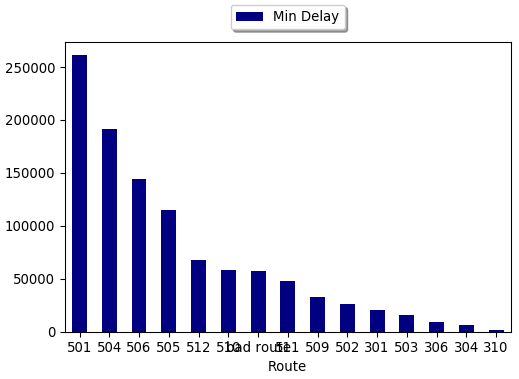

In [ ]:
display(df)